In [1]:
import rootpath
import sys
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
import numpy as np
import time
from testsuite.surrogates import GP, MultiSurrogate
from testsuite.utilities import Pareto_split
from testsuite.optimisers import Saf
saf_measure = Saf.saf
from itertools import product 
from evoalgos.performance import FonsecaHyperVolume
import _csupport as cs 

### process
- scatter points at random 
- process SMS-EGO/SAF
    - time it
    - count bit flips
- do n, times and box plot
- repeat process for objectives 2-6

In [2]:
def simplex_sample(n_dim, H):
    sj = np.array([i/H for i in range(H+1)])
    
    s = []
    for c in product(sj, repeat=n_dim):
        if np.sum(c) == 1:
            s.append(c)
    return np.array(s)

def gen_nondominated(n_dim, n):
    points = np.abs(np.random.multivariate_normal(np.zeros(n_dim), np.diag(np.ones(n_dim)), n))
    norms =  np.linalg.norm(points, axis=1)
    return (points.T/norms).T

In [3]:
def compute_hypervolume(p=None):
    """
    Calcualte the current hypervolume, or that of the provided y.
    """
    volume = HV_CALC.assess_non_dom_front(p)
    return volume


def compute_epsilon(p_scaled, n_objectives):
    n_pfr = len(p_scaled)
    c = 1 - (1 / 2 ** n_objectives)

    # TODO is b_count supposed to be the remaining budget?
    b_count = 100
    epsilon = (p_scaled.max(axis=0) - p_scaled.min(axis=0)) \
              / (n_pfr + (c*b_count))
    return epsilon

def sms_measure(p, y_put, std_put):
    n_obj = p.shape[1]
    gain = 0.1

    # lower confidence bounds
    lcb = y_put + (gain * std_put)

    yt = lcb + (compute_epsilon(p, n_obj))
    l = [-1 + np.prod(1 + lcb - p_i)
         if cs.compare_solutions(p_i, yt, [-1, -1]) == 0
         else 0 for p_i in p]

    penalty = (max([0, max(l)]))

    # penalty = self._compute_penalty(lcb, p)

    if penalty > 0:
        return -penalty
    else:
        # compute and update hypervolumes
        current_hv = 0.654
        # we use vstack(self.p, lcb) here without Pareto_split becasue
        # it is more efficient and gives the same answer. Verified
        # TODO create temporary class variable to store best hv so that
        #  it does not have to be recomputed in self.step
        put_hv = compute_hypervolume(np.vstack((p, y_put)))
        
    return put_hv - current_hv

In [4]:
def tf(f, args):
    tic = time.time()
    f(*args)
    return time.time() - tic

In [5]:
n_points = 10451
n_dim = 3
points = gen_nondominated(n_dim, n_points)
p_points, d_points = Pareto_split(points)
assert d_points.shape[0] == 0
assert p_points.shape[0] == n_points
assert p_points.shape[1] == n_dim 

In [26]:
sample_ns = np.logspace(1, 2.48, 10, dtype=int)
sample_dims = np.arange(2,10)
print(sample_ns)
print(sample_dims) 

[ 10  14  21  31  45  66  96 141 206 301]
[2 3 4 5 6 7 8 9]


In [7]:
n_dims = 2

In [8]:
%time

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


In [9]:
n_dims = 2
HV_CALC = FonsecaHyperVolume(reference_point=np.ones(n_dims)*2)
ps = gen_nondominated(n_dims, 1000)[:100]
ref_point = np.zeros(n_dims).reshape(1, -1)
ps.shape

print(ps.shape)
print(ref_point.shape)

(100, 2)
(1, 2)


In [10]:
%timeit saf_measure(ps, ref_point);

20.9 µs ± 1.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit sms_measure(ps, ref_point, 0.1);

897 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
saf_t = 847*10**-6
print(saf_t)

0.000847


In [13]:
sms_t = 51.1*10**-3
print(sms_t)

0.0511


In [14]:
sms_t/saf_t

60.33057851239669

In [27]:
n_repeats = 50
n_comb = len(sample_dims)*len(sample_ns)
saf_results = {n_dims: np.zeros((len(sample_ns), n_repeats)) for n_dims in sample_dims}
sms_results = {n_dims: np.zeros((len(sample_ns), n_repeats)) for n_dims in sample_dims}
i_map = {n: i for n, i in zip(sample_ns, range(len(sample_ns)))}

for n_dims, n_samples in product(sample_dims, sample_ns):
    HV_CALC = FonsecaHyperVolume(reference_point=np.ones(n_dims)*2)
    points = gen_nondominated(n_dims, n_samples)
    ref_point = np.zeros(n_dims)
    tsaf = [tf(saf_measure, (points, ref_point)) for i in range(n_repeats)]
    tsms = [tf(sms_measure, (points, ref_point, 0.1)) for i in range(n_repeats)]
    saf_results[n_dims][i_map[n_samples]] = tsaf
    sms_results[n_dims][i_map[n_samples]] = tsms

In [36]:
import matplotlib
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['figure.figsize'] = (10, 8)

Text(0.5, 1.0, 'SMS-EGO')

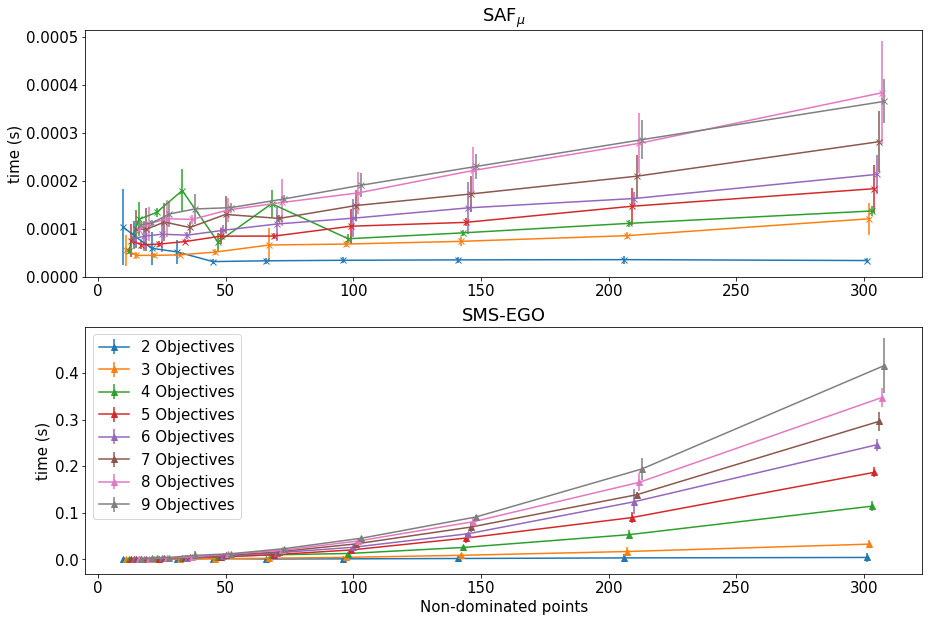

In [40]:
fig = plt.figure(figsize=[15, 10])
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
for i, (n, r), r2 in zip(range(len(saf_results)), saf_results.items(), sms_results.values()):
    ax0.errorbar(sample_ns+i, r.mean(axis=1), r.std(axis=1), label='{} Objective SAF'.format(n), marker="x", c="C{}".format(int(i)))
    ax1.errorbar(sample_ns+i, r2.mean(axis=1), r2.std(axis=1), label='{} Objectives'.format(n), marker="^", c="C{}".format(int(i)))
#     plt.fill_between(sample_ns, r.mean(axis=1)-r.std(axis=1), r.mean(axis=1)+r.std(axis=1), alpha=0.2)
ax1.legend()
# ax.set_yscale('log')
ax1.set_xlabel("Non-dominated points")
ax0.set_ylabel("time (s)")
ax1.set_ylabel("time (s)")

ax0.set_title(r"SAF$_{\mu}$")
ax1.set_title(r"SMS-EGO")

In [29]:
0.4/0.0003

1333.3333333333335

In [19]:
0.025/0.00021

119.04761904761905

In [33]:
Pareto_split(gen_nondominated(7, 100))[0].shape

(100, 7)